In [1]:
import random
import re
import json
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import gensim
import pickle

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.utils import to_categorical

from CustomGenerator import CustomGenerator
from tools import load_data,configuration_fn,tsne_plot_similar_words,build_model,build_w2v_model
from tools import read_glove_vecs,sentences_to_indices,pretrained_embedding_layer,convert_to_one_hot

Using TensorFlow backend.


Read configuration from yml file

In [2]:
cfg = yaml.safe_load(open(configuration_fn))
fn = cfg['input']
MODEL_FILENAME = cfg['output']

In [3]:
np.random.seed(cfg['RANDOM_SEED'])

More configuration

In [4]:
NUMBER_WORDS_TO_REVIEW = 15
WORD_TO_TEST = 'washington'
CLOSEST_COUNT = 10
NUMBER_OF_CLUSTERS = 15
num_words = 2000

In [5]:
print(fn)

data/amazon_alexa.tsv


In [6]:
data = pd.read_csv(fn, delimiter = '\t', quoting = 3)

Review data

In [7]:
print(f'we have {len(data)} lines of data')
data = data.sample(frac=1)

we have 3150 lines of data


In [8]:
data.head()

,rating,date,variation,verified_reviews,feedback
2965,5,30-Jul-18,Black Dot,"""Love it, we are still learning the capabiliti...",1
969,5,29-Jul-18,Heather Gray Fabric,Very easy setup.,1
1385,5,17-Jul-18,Black Spot,,1
1233,5,26-Jul-18,Black Spot,"""I purchased this on prime day mostly as a pre...",1
2996,5,30-Jul-18,White Dot,Fun and information. No dislikes so far !! ...,1


# Cleanup and features: 
    lowercase
    remove digits
    parse annotation
    remove redundencies
    remove empty column extras

In [9]:
data['content'] = data['verified_reviews'].str.lower()
data['content'] = data['content'].str.replace('[^a-z\s]', '')
data['annotation']=data['rating'].apply(lambda x: int(x/5))
data.drop_duplicates(subset = "content", inplace=True)

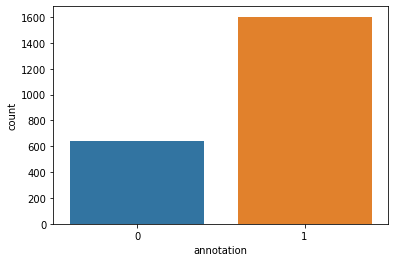

In [10]:
sns.countplot(x='annotation', data=data)

Take a small balanced subset of the data, include positives and negatives

In [11]:
number_of_offsentive_annotations = len(data[data['annotation']==0])
print("bad reviews:",number_of_offsentive_annotations)

bad reviews: 639


In [12]:
data = pd.concat([data[data['annotation']==0] , data[data['annotation']==1][:number_of_offsentive_annotations]])

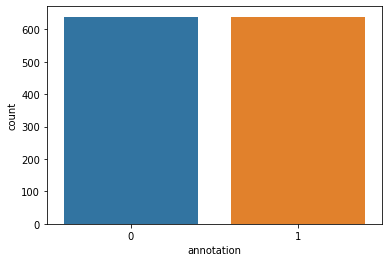

In [13]:
sns.countplot(x='annotation', data=data)

In [14]:
print(f'We now have {len(data)} data points')
data.head()

We now have 1278 data points


,rating,date,variation,verified_reviews,feedback,content,annotation
1239,4,26-Jul-18,White Spot,Speakers are not as loud as Google Home,1,speakers are not as loud as google home,0
2397,2,30-Jul-18,Configuration: Fire TV Stick,las películas no tiene o no se pueden cambiar ...,0,las pelculas no tiene o no se pueden cambiar a...,0
1450,2,30-Jul-18,Black Show,Thought it would be more powerful and have a l...,0,thought it would be more powerful and have a l...,0
612,4,3-Jun-18,Black,Worked as advertised. Thanks,1,worked as advertised thanks,0
2500,1,30-Jul-18,Black Dot,I didn't like that almost everytime i asked Al...,0,i didnt like that almost everytime i asked ale...,0


In [15]:
lens = data.content.str.len()
#maxLen = max(lens)
avg = lens.mean()
print(f'Mean tweet length: {avg:10.1f}')

Mean tweet length:      157.2


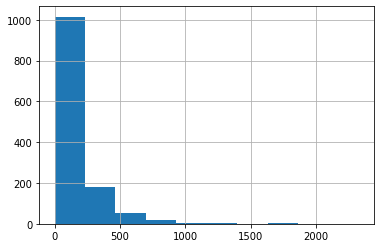

In [16]:
lens.hist()

Build train / test set

# TFiDF + SVM

In [17]:
Y = data['annotation'].values
X_train, X_test, y_train, y_test = train_test_split(data['content'].values, Y,
                                                    test_size = cfg['TEST_FRACTION2_LSTM_W2V'],
                                                    random_state = cfg['RANDOM_SEED'], stratify=Y)

In [18]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()),
])

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                     

In [20]:
############
# Evaluate #
############
categories = ['negative' , 'positive']

predicted = pipeline.predict(X_test)
print(metrics.classification_report(y_test, predicted,
                                    target_names=categories))
metrics.confusion_matrix(y_test, predicted)

              precision    recall  f1-score   support

    negative       0.75      0.77      0.76        64
    positive       0.76      0.75      0.76        64

    accuracy                           0.76       128
   macro avg       0.76      0.76      0.76       128
weighted avg       0.76      0.76      0.76       128



array([[49, 15],
       [16, 48]])

In [22]:
model = pipeline[2]
count_vect = pipeline[0]

In [23]:
threshold = sorted(list(model.coef_[0]))[-100]
revdict = dict((count_vect.vocabulary_[k],k) for k in iter(count_vect.vocabulary_))
print([revdict[i] for i,x in enumerate(model.coef_[0]) if x>threshold])

['able', 'about', 'added', 'additional', 'advertised', 'all', 'amaxing', 'amazing', 'arrived', 'ask', 'awesome', 'being', 'best', 'bigger', 'call', 'capabilitiesbut', 'compact', 'condition', 'course', 'crazy', 'dad', 'dims', 'easier', 'easy', 'entire', 'everyone', 'exactly', 'excellent', 'expert', 'extended', 'favorite', 'flawlessly', 'friendly', 'from', 'fun', 'getting', 'great', 'group', 'highly', 'httpswwwamazoncomdpbsqyxtwrefcmcrrypprdttlsol', 'im', 'information', 'installing', 'keeper', 'keyboard', 'knew', 'lag', 'learn', 'leary', 'lets', 'life', 'lists', 'live', 'long', 'loud', 'love', 'loved', 'made', 'minutes', 'movies', 'music', 'needed', 'new', 'news', 'now', 'office', 'perfect', 'perfectly', 'powerful', 'programmed', 'purchased', 'really', 'recommend', 'room', 'savvy', 'say', 'searching', 'since', 'sister', 'st', 'such', 'tell', 'thermostat', 'things', 'timer', 'unit', 'upgraded', 'usage', 'very', 'wait', 'wanted', 'what', 'while', 'whole', 'wife', 'wireless', 'wonderful', '

In [24]:
y_score = pipeline.decision_function(X_test)

In [25]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#for i in range(2):
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

In [26]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

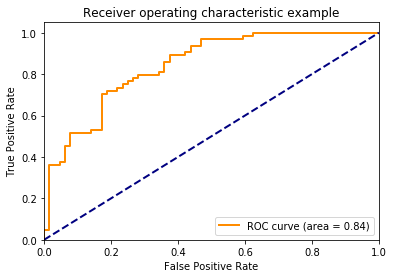

In [27]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# LSTM + W2V

In [28]:
Y = convert_to_one_hot(data['annotation'].values, 2)
X_train, X_test, y_train, y_test = train_test_split(data['content'].values, Y,
                                                    test_size = cfg['TEST_FRACTION2_LSTM_W2V'],
                                                    random_state = cfg['RANDOM_SEED'], stratify=Y)

In [29]:
%%time
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

CPU times: user 5.7 s, sys: 229 ms, total: 5.93 s
Wall time: 5.96 s


In [30]:
maxLen = len(max(X_train, key=len).split())
print(maxLen)
maxLen = 25

451


In [31]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices =  sentences_to_indices(X_test,  word_to_index, maxLen)

In [32]:
print(len(X_train[380].split()))

16


In [33]:
len(max(X_train, key=len))

2329

In [34]:
print(f'Size of train: {len(X_train)} size of test: {len(X_test)}')

Size of train: 1150 size of test: 128


In [35]:
model_w2v = build_w2v_model(word_to_vec_map, word_to_index, maxLen)
model_w2v.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 256)           314368    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                

In [36]:
%%time
generator = CustomGenerator(X_train_indices, y_train)
history = model_w2v.fit_generator(generator=generator, steps_per_epoch=(len(X_train_indices) // generator.batch_size),
                    epochs = cfg['LSTM_W2V_EPOCHS'], verbose = 1, shuffle=True, validation_data=(X_test_indices, y_test))

Epoch 1/15
35/35 [==============================] - 3s 93ms/step - loss: 0.8323 - accuracy: 0.5590 - val_loss: 0.6712 - val_accuracy: 0.5859
Epoch 2/15
35/35 [==============================] - 2s 64ms/step - loss: 0.7642 - accuracy: 0.5555 - val_loss: 0.6766 - val_accuracy: 0.6016
Epoch 3/15
35/35 [==============================] - 2s 68ms/step - loss: 0.7154 - accuracy: 0.5769 - val_loss: 0.6406 - val_accuracy: 0.6016
Epoch 4/15
35/35 [==============================] - 2s 70ms/step - loss: 0.6819 - accuracy: 0.6145 - val_loss: 0.6306 - val_accuracy: 0.6016
Epoch 5/15
35/35 [==============================] - 2s 66ms/step - loss: 0.6331 - accuracy: 0.6664 - val_loss: 0.6722 - val_accuracy: 0.6641
Epoch 6/15
35/35 [==============================] - 2s 66ms/step - loss: 0.6082 - accuracy: 0.7030 - val_loss: 0.5782 - val_accuracy: 0.6562
Epoch 7/15
35/35 [==============================] - 2s 70ms/step - loss: 0.6576 - accuracy: 0.6592 - val_loss: 0.5844 - val_accuracy: 0.6953
Epoch 8/15
35


Calculate accuracy on the test set

In [37]:
%%time
test_mse  = model_w2v.evaluate(X_test_indices,  y_test)
train_mse = model_w2v.evaluate(X_train_indices, y_train)
print(test_mse)

1150/1150 [==============================] - 1s 495us/step
[0.5758680328726768, 0.6875]
CPU times: user 2.11 s, sys: 642 ms, total: 2.75 s
Wall time: 648 ms


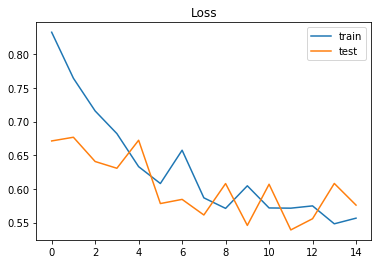

In [38]:
# evaluate the model
#print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

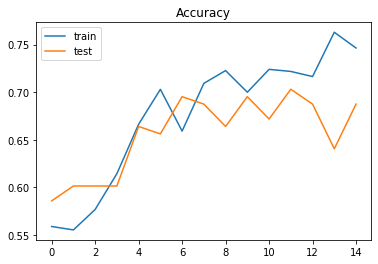

In [39]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

see the mislabelled examples

In [40]:
%%time
pred = model_w2v.predict(X_test_indices)
pred_indices = np.argmax(pred, axis=1)
classes = np.array(range(0, 2))
predicted = classes[pred_indices]
yt = [int(x[1]) for x in y_test]
print(metrics.classification_report(yt, predicted))
print(metrics.confusion_matrix(yt, predicted))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        64
           1       0.71      0.64      0.67        64

    accuracy                           0.69       128
   macro avg       0.69      0.69      0.69       128
weighted avg       0.69      0.69      0.69       128

[[47 17]
 [23 41]]
CPU times: user 419 ms, sys: 74.2 ms, total: 493 ms
Wall time: 281 ms


Example

In [41]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['please go and the arrive'])
print(X_test_indices)
print(x_test[0] +' '+  str((model_w2v.predict(X_test_indices))))

[[377946. 132683. 326012. ...      0.      0.      0.]
 [148356.  81794. 269953. ... 148444.      0.      0.]
 [226278. 357266. 128201. ... 304093.  60665. 357810.]
 ...
 [185457. 295456. 357266. ... 268046. 159622. 185457.]
 [269953. 292794. 394475. ... 281272.      0.      0.]
 [384374. 226278. 357266. ... 272881. 191507. 193637.]]
please go and the arrive [[0.6277974  0.37220252]
 [0.81452125 0.18547876]
 [0.5465309  0.45346913]
 [0.09178655 0.90821344]
 [0.07769308 0.9223069 ]
 [0.22678113 0.77321887]
 [0.7584452  0.24155481]
 [0.8436326  0.15636748]
 [0.21185279 0.78814715]
 [0.6312942  0.36870584]
 [0.80189663 0.19810332]
 [0.08353228 0.9164677 ]
 [0.21249184 0.7875082 ]
 [0.6202684  0.37973163]
 [0.24587218 0.75412774]
 [0.25641888 0.7435811 ]
 [0.1079719  0.8920281 ]
 [0.47826958 0.5217304 ]
 [0.9333483  0.06665168]
 [0.79837775 0.20162217]
 [0.6002278  0.39977223]
 [0.80940205 0.190598  ]
 [0.14731403 0.852686  ]
 [0.904074   0.09592599]
 [0.2766287  0.7233713 ]
 [0.91316813 0

See the mislabelled examples

In [42]:
for i in range(len(X_test)):
    num = np.argmax(pred[i])
    if(num != yt[i]):
        print( str(X_test[i]) + ' prediction: '+ str(pred[i]) + str(num))

very easy setup prediction: [0.6277974  0.37220252]0
finally bought one but it couldnt find my wifi had to buy a wifi extended my smart tv used the wifi just fine prediction: [0.81452125 0.18547876]0
love the dots especially with the ability to talk from one to the other these are really convenient no issues with the refurbished as they are like new prediction: [0.5465309  0.45346913]0
as always easy to set up prediction: [0.21185279 0.78814715]1
i love alexa but the sound on the dot is not the best i own an echo nd gen for the kitchenliving room and got this for my bedroom but theres a significant difference in sound the dot lacks a full base sound and sounds as if its coming off a cheap portable speaker i was really disappointed i returned it right away and just shelled out the money to buy a second echo  for my bedroom also prediction: [0.47826958 0.5217304 ]1
so far i like it  it is better than i expecting it prediction: [0.79837775 0.20162217]0
very nice everything is working fine

# Output

In [43]:
pickle.dump(model_w2v, open(MODEL_FILENAME,'wb'))